# 프로젝트: 뉴스기사 요약해보기

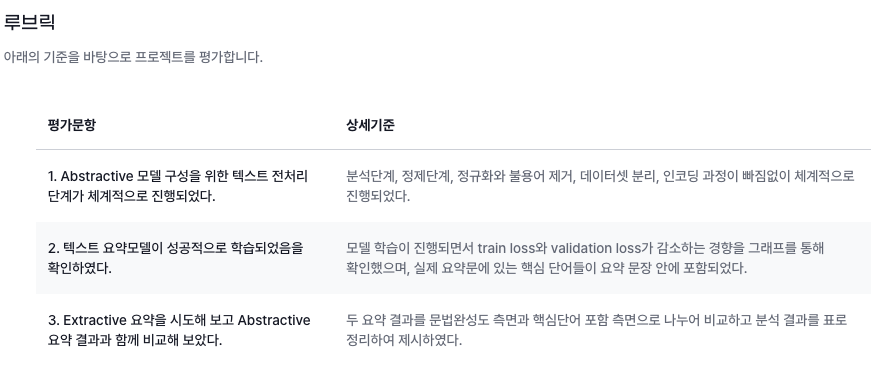

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup 
from autocorrect import Speller
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

2024-11-27 22:51:25.700132: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


3.9.1
2.13.1
2.0.3
1.2.0


## 데이터수집

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
88781,"I am going to report Anushka for stalking me, ...",Actor Shah Rukh Khan recently reposted a photo...
50009,Apple to cut iPhone X production target by hal...,Apple has notified its suppliers that it's cut...
32707,"2,500 Maha schools, colleges set up Electoral ...","Nearly 2,500 educational institutions across M..."
14779,PM Modi hosts dinner for Russian Prez at Delhi...,"Russian President Vladimir Putin, who is on a ..."
95164,Former Huawei engineer 'marries' robot he buil...,"A former Huawei engineer from China has ""marri..."
28860,"LeT commander among 2 militants killed in J&K,...",Security forces in Jammu and Kashmir killed tw...
51501,AAP moved from 'against corruption' to 'I'm co...,After Election Commission recommended disquali...
55068,18-yr-old Sundar becomes youngest T20I debutan...,Spinner Washington Sundar became the youngest ...
42567,Cong demands review of SC verdict on arrests u...,The Congress has demanded that the Centre file...
94150,Delhi Metro to launch housing scheme with 2BHK...,The Delhi Metro Rail Corporation will launch a...


추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습\
 추출적 요약을 하는 경우에는 오직 text열만을 사용

## 데이터 전처리 (추상적 요약)
- 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제
- 용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [8]:
data['headlines'].nunique(), data['text'].nunique()

(98280, 98360)

In [9]:
# text 중복제거, headline는 제거하지 않음- 요약은 같을 수 있음
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [ ]:
print(data.isnull().sum()) # null값 확인 - 없음

headlines    0
text         0
dtype: int64


In [11]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 정규화 및 불용어 제거

In [12]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [15]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))


불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [22]:
data

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [ ]:
# spell = Speller(lang='en')

# cleaning 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    # sentence = ' '.join([spell(word) for word in sentence.split()])  # 각 단어에 대해 철자 교정 적용 - 추가 , 시간 너무 오래 걸림
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [28]:
# text, headlines에 대해 함수 적용
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

clean_headlines = []
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, remove_stopwords=False))

/tmp/ipykernel_30603/2447732413.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


In [29]:
# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])
print("Summary 전처리 후 결과: ", clean_headlines[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [ ]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [36]:
data.isnull().sum()

headlines    0
text         0
Text         0
Summary      0
dtype: int64

In [37]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [3]:
# 이전에 작업했던 data 불러오기
data = pd.read_csv('/home/mjun/news_data_preprocessing.csv', encoding='iso-8859-1')
data

,text,headlines
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...
...,...,...
98355,crpf jawan tuesday axed death sharp edged weap...,crpf jawan axed to death by maoists in chhatti...
98356,uff yeh first song sonakshi sinha starrer upco...,first song from sonakshi sinha noor titled uff...
98357,according reports new version science fiction ...,the matrix film to get reboot reports
98358,new music video shows rapper snoop dogg aiming...,snoop dogg aims gun at clown dressed as trump ...


### 샘플 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


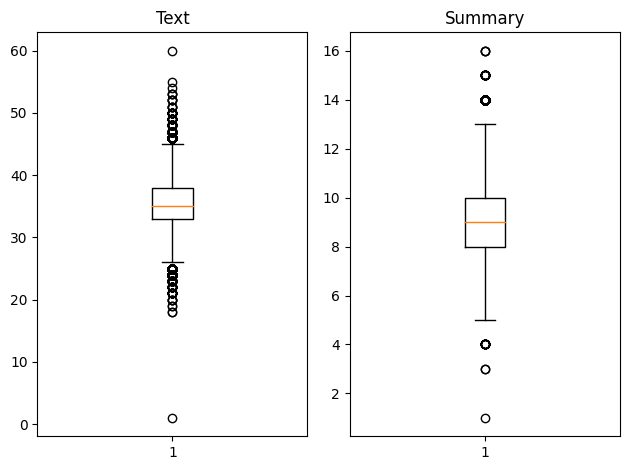

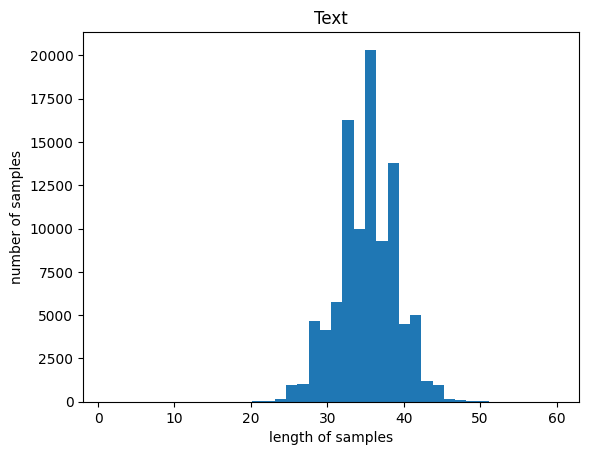

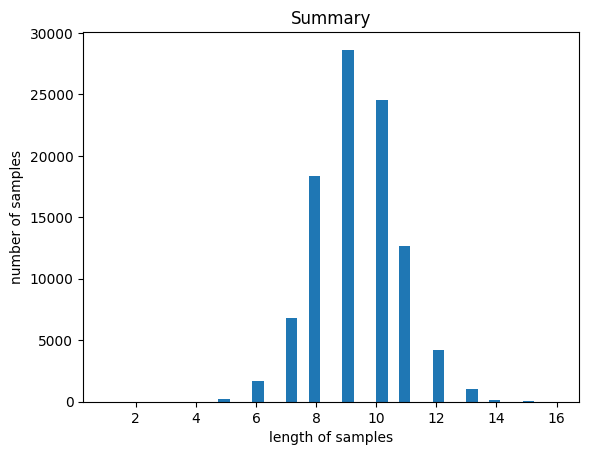

In [5]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [6]:
text_max_len = 40
headlines_max_len = 12

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


이정도로 바로 고고

In [7]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 89775


약 9000개의 샘플이 제거되었다.

시작 토큰 종료 토큰 추가

In [ ]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india recorded lowest odi total new zealand ge...,india get all out for their lowest odi total i...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [9]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [10]:
# 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 데이터 셈플 순서 다시 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

#섞인 데이터 8:2 비율로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val) #테스트 데이터 수 확인해서 몇 개인지 대략 확인

# 데이터 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

테스트 데이터의 수 : 17955
훈련 데이터의 개수 : 71820
훈련 레이블의 개수 : 71820
테스트 데이터의 개수 : 17955
테스트 레이블의 개수 : 17955


단어 집합 만들기

In [11]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [12]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65517
등장 빈도가 6번 이하인 희귀 단어의 수: 44557
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20960
단어 집합에서 희귀 단어의 비율: 68.00830318848543
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.662267090452045


6회 이하 단어 제외, 크기 20,000으로 

In [13]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [14]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[155, 30, 9, 88, 360, 3, 13, 372, 100, 3769, 199, 5820, 17376, 10527, 10821, 356, 7, 1, 59, 18, 230, 148, 11, 230, 10291, 157, 215, 262, 2084, 4256, 1383, 17377, 146, 2], [10292, 8, 46, 428, 3015, 3, 13, 404, 2464, 2709, 852, 2115, 95, 183, 647, 428, 8, 550, 17376, 1383, 93, 1442, 1575, 676, 5446, 18391, 98, 1383, 17377, 404, 1, 836, 17376, 2026, 9, 16505], [36, 769, 849, 51, 15064, 603, 575, 272, 3, 12, 81, 652, 2642, 99, 8712, 51, 12503, 905, 2979, 1286, 729, 2412, 272, 36, 3145, 3265, 1353, 38, 7123, 1255, 132]]


헤드라인도 진행

In [15]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [16]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28894
등장 빈도가 5번 이하인 희귀 단어의 수: 18960
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9934
단어 집합에서 희귀 단어의 비율: 65.61915968713228
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.929193862788913


In [17]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 127, 11, 8334, 4, 284], [1, 95, 367, 2540, 66, 27, 139, 7, 3759], [1, 149, 276, 560, 14, 438, 655, 11, 2541, 397], [1, 1836, 114, 159, 8, 405, 14, 18, 374, 6, 4114], [1, 24, 10, 842, 3987, 278, 536, 501, 6, 106, 444]]
target
decoder  [[127, 11, 8334, 4, 284, 2], [95, 367, 2540, 66, 27, 139, 7, 3759, 2], [149, 276, 560, 14, 438, 655, 11, 2541, 397, 2], [1836, 114, 159, 8, 405, 14, 18, 374, 6, 4114, 2], [24, 10, 842, 3987, 278, 536, 501, 6, 106, 444, 2]]


empty 샘플 제거    

In [18]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 71820
훈련 레이블의 개수 : 71820
테스트 데이터의 개수 : 17954
테스트 레이블의 개수 : 17954


패딩하기

In [19]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post') # transformer 기반일 때 'pre'로 진행

## 어텐션 메커니즘 사용하기 (추상적 요약)
- 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있다. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계

In [20]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

2024-11-27 23:13:40.534857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9621 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-11-27 23:13:40.535582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1518 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-11-27 23:13:40.536001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 1518 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2024-11-27 23:13:40.536554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9604 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

In [21]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [22]:
# 어텐션 층 만들고 디코더 연결
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 40, 128)              2560000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 40, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

모델 훈련

In [23]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # 과적합 보기위해 주석처리
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, epochs=50, verbose=1)

Epoch 1/50


2024-11-27 23:14:50.148426: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2080 Ti" frequency: 1650 num_cores: 68 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5767168 shared_memory_size_per_multiprocessor: 65536 memory_size: 10088873984 bandwidth: 616000000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2024-11-27 23:14:54.093447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801
2024-11-27 23:14:55.216356: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6f58556c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Dev

281/281 [==============================] - ETA: 0s - loss: 5.8235

2024-11-27 23:15:54.260475: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2080 Ti" frequency: 1650 num_cores: 68 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5767168 shared_memory_size_per_multiprocessor: 65536 memory_size: 10088873984 bandwidth: 616000000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


281/281 [==============================] - 69s 210ms/step - loss: 5.8235 - val_loss: 5.4914
Epoch 2/50
281/281 [==============================] - 24s 84ms/step - loss: 5.4968 - val_loss: 5.4134
Epoch 3/50
281/281 [==============================] - 21s 74ms/step - loss: 5.3986 - val_loss: 5.3340
Epoch 4/50
281/281 [==============================] - 15s 53ms/step - loss: 5.3041 - val_loss: 5.2045
Epoch 5/50
281/281 [==============================] - 13s 48ms/step - loss: 5.1651 - val_loss: 5.0678
Epoch 6/50
281/281 [==============================] - 12s 44ms/step - loss: 5.0271 - val_loss: 4.9564
Epoch 7/50
281/281 [==============================] - 13s 46ms/step - loss: 4.9188 - val_loss: 4.8834
Epoch 8/50
281/281 [==============================] - 12s 44ms/step - loss: 4.8212 - val_loss: 4.7759
Epoch 9/50
281/281 [==============================] - 13s 46ms/step - loss: 4.7187 - val_loss: 4.6947
Epoch 10/50
281/281 [==============================] - 12s 43ms/step - loss: 4.6281 - val_lo

시각화

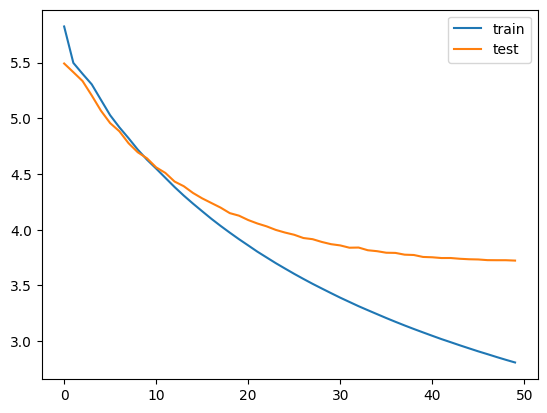

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

val_loss 꾸준히 떨어지고 있긴하지만 과적합 징조가 보임

인퍼런스 모델 구축

In [25]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [26]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


어텐션 메커니즘 출력

In [27]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


인퍼런스 단계에서 단어 시퀀스 완성 함수 구현

In [31]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 실제 결과와 요약문 비교하기 (추상적 요약)
- 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해

In [32]:
# 원문의 정수 시퀀스를 텍스트로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [34]:
# 20개만 추출
for i in range(50, 70):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 헤드라인 :", seq2summary(decoder_input_test[i]))
    print("예측 헤드라인 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : spacex falcon heavy rocket world powerful operational rocket liftoff thrust million pounds pound load capacity nasa upcoming space launch system million pounds liftoff thrust pound capacity one falcon heavy launch cost million whereas price expected billion 
실제 헤드라인 : how spacex rocket fares against nasa upcoming 
1/1 [==============================] - 0s 20ms/step
예측 헤드라인 :  spacex launches world most powerful rocket at


원문 : british rider daniel died crash macau motorcycle grand prix saturday year old came bike sharp bend lost helmet hitting barriers sustaining fatal injuries sixth lap race laid track died way hospital 
실제 헤드라인 : year old dies in crash at grand prix 
1/1 [==============================] - 0s 21ms/step
예측 헤드라인 :  man dies after falling into race in race


원문 : bollywood actress sunny leone wednesday accepted chris gayle dance challenge twitter sent original laila main laila song video entry replying leone post gayle wrote seeing got moves gayle announced reward 

몇가지 봤는데 실제 헤드라인보단 예측 헤드라인이 잘 뽑힌 느낌

## Summa을 이용해서 추출적 요약해보기

In [65]:
# data 다시 load
# text 데이터만 사용
data = pd.read_csv('/home/mjun/news_summary_more.csv', encoding='iso-8859-1')
data

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [ ]:
from summa.summarizer import summarize

# 실제 헤드라인과 예측 헤드라인을 비교 함수 (상위 10개, ratio=0.5 적용)
def top_n_compare_summary(data, ratio=0.5, n=10):
    # 상위 n개의 데이터만 처리
    data = data.head(n)
    
    for i in range(len(data)):
        text = data['text'].iloc[i]
        actual_headlines = data['headlines'].iloc[i]
        
        # 예측 헤드라인 생성 (텍스트 요약)
        predicted_headline = summarize(text, ratio=ratio)

        # 비교 출력
        print(f"원문: {text}")
        print(f"실제 헤드라인: {actual_headlines}")
        print(f"예측 헤드라인: {predicted_headline}")
        print("\n")

# 상위 10개 샘플을 대상으로 비교 (ratio=0.5)
top_n_compare_summary(data, ratio=0.5, n=10)

원문: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 헤드라인: upGrad learner switches to career in ML & Al with 90% salary hike
예측 헤드라인: upGrad's Online Power Learning has powered 3 lakh+ careers.


원문: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 헤드라인: Delhi techie wins free food from Swiggy for one year on CRED
예측 헤드라인: Users get one CRED coin per rupee of bill p

## 회고

- 할일은 제때 하자
- 요약이 막 잘된 느낌은 아니지만 문제 없이 잘 돌아간게 어딘가.. 다름에는 한국어 요약문 해봐야겠다.
- transformer 기반의 모델을 부터 다시 차근차근 적용해서 최신 모델까지 추가 실험 해보자